In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autoam-car-price-prediction/sample_submission.csv
/kaggle/input/autoam-car-price-prediction/train.csv
/kaggle/input/autoam-car-price-prediction/test.csv


In [2]:
#upload the train.csv file as train_data
train_data = pd.read_csv('/kaggle/input/autoam-car-price-prediction/train.csv')
X_test = pd.read_csv('/kaggle/input/autoam-car-price-prediction/test.csv')

In [3]:
train_data.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


In [4]:
X_test.head()

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8


In [5]:
train_data.shape

(1642, 10)

In [6]:
train_data = train_data.drop('wheel', axis=1)
X_test = X_test.drop('wheel', axis=1)

<Axes: title={'center': 'price'}, xlabel='model'>

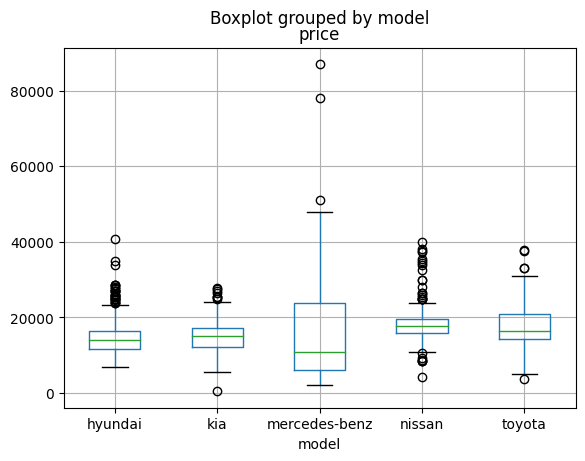

In [7]:
train_data.boxplot(column='price', by='model')

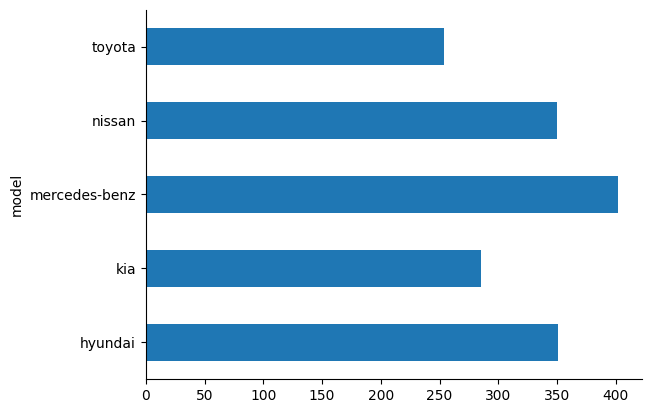

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('model').size().plot(kind='barh')
plt.gca().spines[['top', 'right',]].set_visible(False)

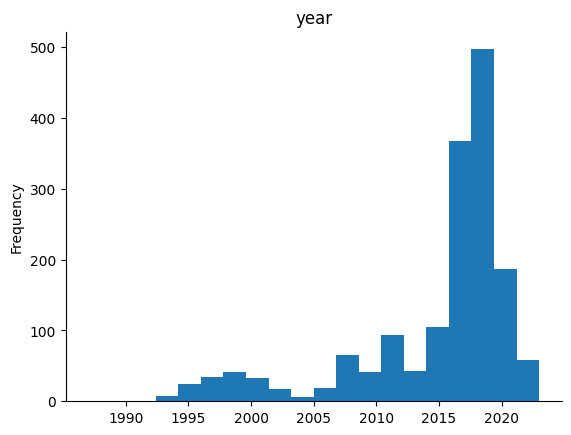

In [9]:
from matplotlib import pyplot as plt
train_data['year'].plot(kind='hist', bins=20, title='year')
plt.gca().spines[['top', 'right',]].set_visible(False)

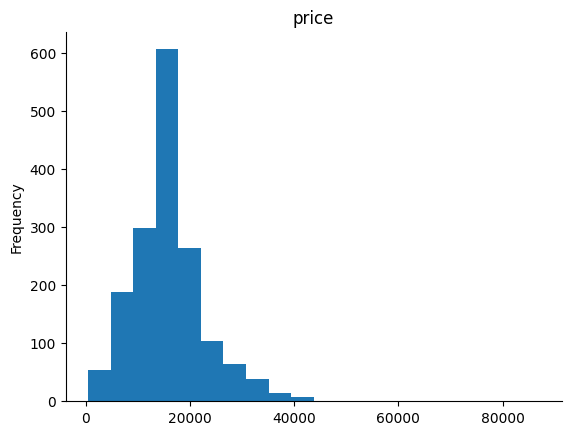

In [10]:
train_data['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1642 non-null   object 
 1   year          1642 non-null   int64  
 2   motor_type    1642 non-null   object 
 3   running       1642 non-null   object 
 4   color         1642 non-null   object 
 5   type          1642 non-null   object 
 6   status        1642 non-null   object 
 7   motor_volume  1642 non-null   float64
 8   price         1642 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 115.6+ KB


In [12]:
train_data.duplicated().sum()

9

In [13]:
train_data.drop_duplicates(inplace=True)

In [14]:
def remove_noise(data, column_name):
  # Calculate the median and standard deviation of the column.
  median = data[column_name].median()
  std = data[column_name].std()

  # Define the upper and lower bounds for valid values.
  lower_bound = median - 3 * std
  upper_bound = median + 3 * std

  # Create a new DataFrame with the noise removed.
  clean_data = data.copy()
  clean_data[column_name] = np.clip(data[column_name], lower_bound, upper_bound)

  return clean_data

# Remove noise from the "price" column.
train_data = remove_noise(train_data, "price")

# Print the new DataFrame.
train_data.head()

,model,year,motor_type,running,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,skyblue,sedan,excellent,2.0,24500.0
1,mercedes-benz,2014,petrol,132000 km,black,sedan,excellent,2.0,25500.0
2,kia,2018,petrol,95000 miles,other,sedan,excellent,2.0,11700.0
3,mercedes-benz,2002,petrol,137000 miles,golden,sedan,excellent,3.2,12000.0
4,mercedes-benz,2017,petrol,130000 km,black,sedan,good,2.0,26000.0


In [15]:
for column in train_data.columns:
    if train_data[column].dtype=='object':
        print(train_data[column].value_counts())
        print('------------------------------------')

model
mercedes-benz    401
nissan           349
hyundai          347
kia              283
toyota           253
Name: count, dtype: int64
------------------------------------
motor_type
petrol            1412
gas                165
petrol and gas      53
diesel               2
hybrid               1
Name: count, dtype: int64
------------------------------------
running
300000  km      19
70000  miles    18
120000  km      16
65000  miles    15
60000  miles    15
                ..
201000  km       1
8800  km         1
101  miles       1
96122  km        1
68900  miles     1
Name: count, Length: 643, dtype: int64
------------------------------------
color
black      537
white      406
silver     220
gray       188
blue       141
red         47
other       30
cherry      20
green       10
brown       10
golden       6
orange       5
beige        5
clove        3
purple       2
skyblue      2
pink         1
Name: count, dtype: int64
------------------------------------
type
sedan          

In [16]:
ids = X_test['Id']
X_test = X_test.drop('Id', axis=1)

In [17]:
#split the train_data to train data and labels
X_train_full = train_data.drop('price', axis=1)
y_train_full = train_data['price']

In [18]:
def convert_miles_to_kilometers(distance_str):
    if 'miles' in distance_str.lower():
        miles = float(distance_str.split()[0])
        kilometers = miles * 1.60934
        return kilometers
    else:
        return float(distance_str.split()[0])

In [19]:
X_train_full['running'] = X_train_full['running'].apply(convert_miles_to_kilometers)
X_test['running'] = X_test['running'].apply(convert_miles_to_kilometers)

In [20]:
X_train_full['running_per_year'] =  X_train_full['running'] / X_train_full['year']
X_train_full['year_per_running'] = X_train_full['year'] / X_train_full['running']
X_train_full['running_sq'] = X_train_full['running'] **2
X_train_full['year_sq'] = X_train_full['year'] **2
X_train_full['running_for_years'] =  2024- X_train_full['year']
X_train_full['run_per_year'] = X_train_full['running']/(2024-X_train_full['year'])


X_test['running_per_year'] =  X_test['running'] / X_test['year']
X_test['year_per_running'] = X_test['year'] / X_test['running']
X_test['running_sq'] = X_test['running'] **2
X_test['year_sq'] = X_test['year'] **2
X_test['running_for_years'] = 2024 - X_test['year']
X_test['run_per_year'] = X_test['running']/(2024-X_test['year'])

In [21]:
X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1633 entries, 0 to 1641
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   model              1633 non-null   object 
 1   year               1633 non-null   int64  
 2   motor_type         1633 non-null   object 
 3   running            1633 non-null   float64
 4   color              1633 non-null   object 
 5   type               1633 non-null   object 
 6   status             1633 non-null   object 
 7   motor_volume       1633 non-null   float64
 8   running_per_year   1633 non-null   float64
 9   year_per_running   1633 non-null   float64
 10  running_sq         1633 non-null   float64
 11  year_sq            1633 non-null   int64  
 12  running_for_years  1633 non-null   int64  
 13  run_per_year       1633 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 191.4+ KB


In [22]:
num = X_train_full.select_dtypes(include=['int64', 'float64']).columns
col = X_train_full.select_dtypes(include=['object']).columns

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                      test_size=.1, random_state=42)

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, col)])

In [25]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

forest_reg = RandomForestRegressor()
tree_reg = DecisionTreeRegressor()
XGB_reg = XGBRegressor()
catboost_reg = CatBoostRegressor(loss_function='MAE', silent = True)

In [27]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

def display_scores(models, X_valid=X_valid, y_valid=y_valid):
    name, rmse, mae ,score ,rmse_scores= [],[],[],[],[]
    for model in models:
        name.append(type(model).__name__)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        rmse.append(np.sqrt(mean_squared_error(y_valid, y_pred)))
        mae.append(mean_absolute_error(y_valid, y_pred))
        scores = cross_val_score(model, X_valid, y_valid, scoring="neg_mean_squared_error", cv=10).mean()
        score.append(-scores.T.round(2))
        rmse_scores.append(np.sqrt(-scores.T.round(2)))
    result = pd.DataFrame({'MODEL':name, 'RMSE':rmse, 'MAE':mae, 'SCORES MEAN':score, 'SCORES RMSE':rmse_scores})
    return result.style.highlight_min(subset=['RMSE','MAE', 'SCORES MEAN', 'SCORES RMSE'], color='lightgreen').highlight_max(subset=['RMSE','MAE', 'SCORES MEAN', 'SCORES RMSE'], color='pink')


In [28]:
models = [tree_reg, XGB_reg, catboost_reg,forest_reg]
display_scores(models)

,MODEL,RMSE,MAE,SCORES MEAN,SCORES RMSE
0,DecisionTreeRegressor,3847.319821,2450.198941,15029389.800000,3876.775696
1,XGBRegressor,3089.459739,2175.186238,15210652.980000,3900.083714
2,CatBoostRegressor,2737.167415,1797.264095,14331413.400000,3785.685328
3,RandomForestRegressor,2942.930180,2005.027638,13057153.330000,3613.468324


In [29]:
X_train_full = preprocessor.fit_transform(X_train_full)
X_test = preprocessor.transform(X_test)

In [38]:
import numpy as np
from sklearn.model_selection import GridSearchCV

catboost_reg = CatBoostRegressor(random_state=42, verbose=False)

param_grid = {
    'learning_rate': [0.01, 0.1],
    'depth': [3, 4, 5],
    'l2_leaf_reg': [11, 13, 15],
    'loss_function': ['MAE']
}

grid_search = GridSearchCV(catboost_reg, param_grid, cv=3, scoring='neg_mean_squared_error')


In [39]:
grid_search.fit(X_train_full, y_train_full)

best_model = grid_search.best_estimator_

print('Best parameters:')
print(best_model.get_params())

Best parameters:
{'learning_rate': 0.01, 'depth': 5, 'l2_leaf_reg': 11, 'loss_function': 'MAE', 'verbose': False, 'random_state': 42}


In [41]:
y_pred = best_model.predict(X_test)

In [42]:
result = pd.DataFrame(data={'Id':ids, 'price':y_pred})

In [43]:
result.head(20)

,Id,price
0,0,17800.151449
1,1,16722.643793
2,2,23038.086180
3,3,14813.170061
4,4,5569.845818
5,5,23028.996733
6,6,5444.176175
7,7,6999.947917
8,8,16516.319269
9,9,18725.650426


In [44]:
result.to_csv('submission.csv', index=False)